<a href="https://colab.research.google.com/github/mspatke/Deep-Learning-with-Tensorflow/blob/main/Saving_and_Loading__Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U tensorflow_hub
!pip install -U tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 10.5 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [3]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

In [4]:
#Part 1: Load dataset

(train_examples, validation_examples), info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised= True
)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [5]:
num_classes = info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in train_examples:
  num_training_examples += 1

for example in validation_examples:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [6]:
for i, example in enumerate(train_examples.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [7]:
def format_image(image, label):
  IMAGE_RES = 224
  #resize and normalized to range [0,1]

  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image,label

In [9]:
num_examples = info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches = train_examples.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [10]:
#Part 2: Transfer Learning with tensorflow hub

#downloading mobilenet_v2
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

#first layer - defining the mobilenet model and passing the input size
feature_extracter = hub.KerasLayer(URL,
                                   input_shape = (IMAGE_RES, IMAGE_RES,3))

In [11]:
#freezing the variables in feature extracter layer
feature_extracter.trainable = False

In [13]:
model = tf.keras.Sequential([
  feature_extracter,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches )


Epoch 1/6
81/81 [==============================] - 21s 64ms/step - loss: 0.7478 - accuracy: 0.7256 - val_loss: 0.4578 - val_accuracy: 0.8510
Epoch 2/6
81/81 [==============================] - 4s 52ms/step - loss: 0.3787 - accuracy: 0.8747 - val_loss: 0.3581 - val_accuracy: 0.8810
Epoch 3/6
81/81 [==============================] - 4s 52ms/step - loss: 0.2972 - accuracy: 0.9039 - val_loss: 0.3208 - val_accuracy: 0.8928
Epoch 4/6
81/81 [==============================] - 4s 53ms/step - loss: 0.2498 - accuracy: 0.9210 - val_loss: 0.3042 - val_accuracy: 0.9001
Epoch 5/6
81/81 [==============================] - 4s 52ms/step - loss: 0.2118 - accuracy: 0.9354 - val_loss: 0.2993 - val_accuracy: 0.9001
Epoch 6/6
81/81 [==============================] - 4s 52ms/step - loss: 0.1883 - accuracy: 0.9467 - val_loss: 0.2951 - val_accuracy: 0.9037


In [15]:
#Check the predictions

class_names = np.array(info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [16]:
image_batch, label_batch = next(iter(train_batches.take(1)))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)

predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dandelion', 'sunflowers', 'dandelion', 'sunflowers', 'roses',
       'tulips', 'sunflowers', 'sunflowers', 'sunflowers', 'sunflowers',
       'sunflowers', 'roses', 'tulips', 'sunflowers', 'dandelion',
       'dandelion', 'roses', 'tulips', 'sunflowers', 'roses', 'roses',
       'dandelion', 'dandelion', 'tulips', 'tulips', 'tulips',
       'dandelion', 'dandelion', 'dandelion', 'daisy', 'tulips', 'tulips'],
      dtype='<U10')

In [17]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 3 0 3 4 2 3 2 3 3 3 4 2 3 0 0 4 1 3 4 4 0 0 2 2 2 0 1 0 1 2 2]
Predicted labels:  [0 3 0 3 4 2 3 3 3 3 3 4 2 3 0 0 4 2 3 4 4 0 0 2 2 2 0 0 0 1 2 2]


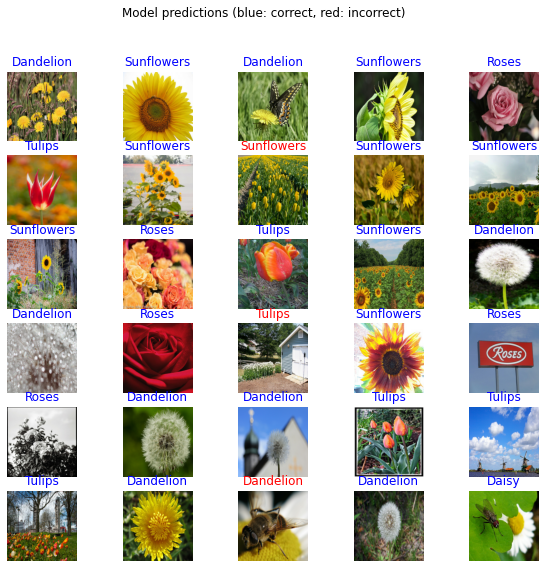

In [18]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")